# Tutorial of network schematas - Bio Models
The network schematas for biological relevant boolean network models

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
from cana.drawing import draw_canalizing_map_graphviz
from cana.drawing import draw_dynamics_canalization_map_graphviz
import matplotlib as mpl
import matplotlib.style
mpl.style.use('classic')
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
import random
from copy import copy
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess
#
import json
import ast


In [3]:
def multi_column_display(objs, titles=['',''], cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'><h3>{{title}}</h3>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=obj,title=title) for obj,title in zip(objs,titles) ]
    cells += (cols - (len(objs)%cols)) * [html_cell.format(content="",title="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [4]:
name = 'leukemia'
d = open('../cana/datasets/{:s}_dict.txt'.format(name), 'r').read()
d = ast.literal_eval(d)
N = cana.BooleanNetwork.from_dict(d, name=name)
foldername = name
print N

<BNetwork(Name='leukemia', N=60, Nodes=['CTLA4', 'TCR', 'PDGFR', 'FYN', 'Cytoskeleton', 'LCK', 'ZAP70', 'GRB2', 'PLCG1', 'RAS', 'GAP', 'MEK', 'ERK', 'PI3K', 'NFKB', 'NFAT', 'RANTES', 'IL2', 'IL2RBT', 'IL2RB', 'IL2RAT', 'IL2RA', 'JAK', 'SOCS', 'STAT3', 'P27', 'Proliferation', 'TBET', 'CREB', 'IFNGT', 'IFNG', 'P2', 'GZMB', 'TPL2', 'TNF', 'TRADD', 'FasL', 'FasT', 'Fas', 'sFas', 'Ceramide', 'DISC', 'Caspase', 'FLIP', 'A20', 'BID', 'IAP', 'BclxL', 'MCL1', 'Apoptosis', 'GPCR', 'SMAD', 'SPHK1', 'S1P', 'PDGF', 'IL15', 'Stimuli', 'Stimuli2', 'CD45', 'TAX'])>


## Effective Graph

In [5]:
Nsg = N.structural_graph()

In [6]:

nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
n = len(nodes)
att = {}

ctr_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if i in [26,4,49]}
ALR = ctr_nodes.keys()
in1_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if Nsg.out_degree(i)==2 and i not in ALR}
ALR.extend(in1_nodes.keys())
in2_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if Nsg.out_degree(i)==1 and i not in ALR}
ALR.extend(in2_nodes.keys())
out_nodes = {i:d['label'] for i,d in Nsg.nodes(data=True) if i not in ALR}

n_in1 = len(in1_nodes)
n_in2 = len(in2_nodes)
n_out = len(out_nodes)
n_ctr = len(ctr_nodes)
r_ctr = .85
r_in1 = 2.5
r_in2 = 3.75
r_out = 5

ctr = max([r_in1,r_out,r_ctr])/2

for deg,(nid,label) in zip( np.linspace(0,360,n_in1,False), in1_nodes.items()):
    x, y = round(ctr + r_in1*math.cos(math.radians(deg)),2), round(ctr + r_in1*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_in2,False), in2_nodes.items()):
    x, y = round(ctr + r_in2*math.cos(math.radians(deg)),2), round(ctr + r_in2*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(0,360,n_out, False), out_nodes.items()):
    x, y = round(ctr + r_out*math.cos(math.radians(deg)),2), round(ctr + r_out*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'#515660'}
for deg,(nid,label) in zip( np.linspace(90,330,n_ctr), ctr_nodes.items()):
    x, y = round(ctr + r_ctr*math.cos(math.radians(deg)),2), round(ctr + r_ctr*math.sin(math.radians(deg)),2)
    pos = '{:.2f},{:.2f}!'.format(x,y)
    att[nid] = {'label':label,'pos':pos,'fillcolor':'red', 'width':'.99', 'shape':'oval'}

Nodes: 60 | Edges: 147


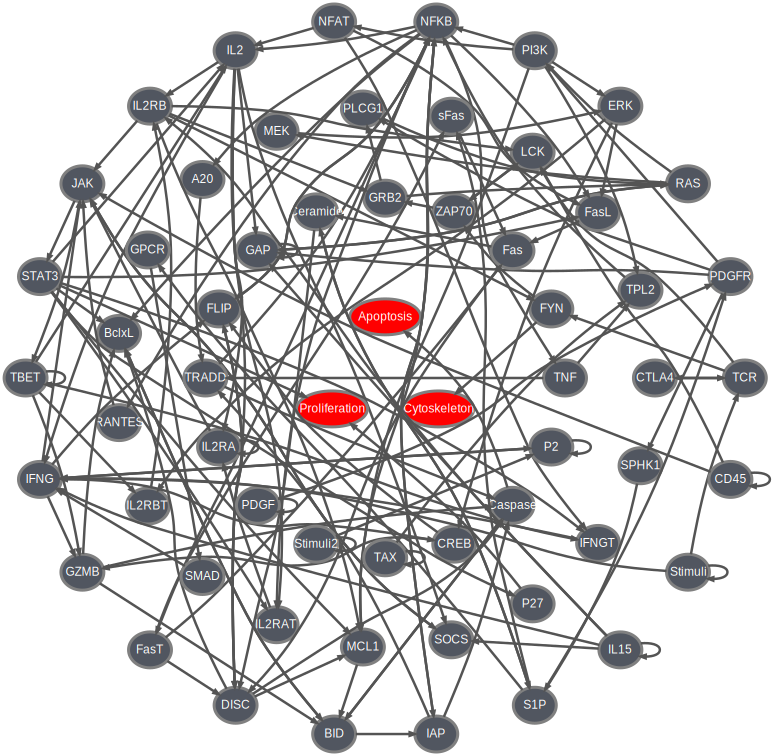

0

In [7]:
# Draw the Structural Graph
S = graphviz.Digraph(name='Structural Graph', engine='neato')
S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='true')
S.attr('node', shape='oval', fixedsize='true', width='.60', color='gray', style='filled', fillcolor='#515660', penwidth='3', fontname='Helvetica', fontcolor='white',fontsize='12')
S.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for nid,d in Nsg.nodes(data=True):
    natt = att[nid]
    S.node(name=str(nid), **natt)

max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, )
print 'Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) )
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})
# Export
S._format = 'svg'
efile = u"%s/../experiments/2017 - BioModels/%s/graphs/SG" % (os.getcwd(),foldername)
S.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [322]:
# Calculate Effective Graph
threshold = 0.00
Neg = N.effective_graph(mode='input',bound='upper', threshold=threshold)

Nodes: 60 | Edges: 147


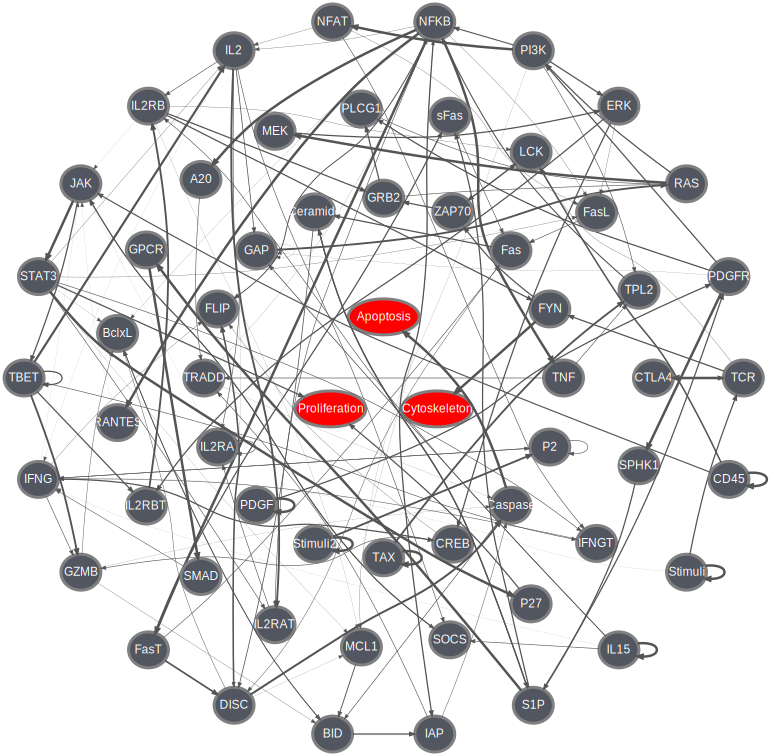

0

In [338]:
# Draw the Effective Graph
E = graphviz.Digraph(name='Effective Graph', engine='neato')
E.attr('graph', concentrate='false', simplify='false', splines='true')
E.attr('node', shape='oval', fixedsize='true', width='.55', color='grey', style='filled', fillcolor='#515660', penwidth='3', fontname='Helvetica', fontcolor='white',fontsize='12')
E.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for nid,d in Nsg.nodes(data=True):
    natt = att[nid]
    E.node(name=str(nid), **natt)

max_penwidth = 2.5
for s,t,d in Neg.edges(data=True):
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    E.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled)
    
print 'Nodes: %d | Edges: %d' % (len(Neg.nodes()) , len(Neg.edges()) )
# Display
display(SVG(E.pipe(format='svg')),metadata={'isolated':True})
# Export
E._format = 'svg'
efile = u'%s/../experiments/2017 - BioModels/%s/graphs/EG' % (os.getcwd(),foldername)
E.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [331]:
bound = 'upper'
print N.nodes[1].schemata_look_up_table(type="ts")
df = pd.DataFrame({
        'node':[n.name for n in N.nodes],
        'k':[n.k for n in N.nodes],
        'k_r':[n.input_redundancy(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_e':[n.effective_connectivity(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_s':[n.input_symmetry(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_r*':[n.input_redundancy(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_e*':[n.effective_connectivity(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_s*':[n.input_symmetry(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_e(out-d)':[v for n,v in Neg.out_degree()],
        'k_e(out-s)':[v for n,v in Neg.out_degree(weight='weight')],
    }).set_index('node')
df = df[['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)']]
print df
efile = u'%s/../experiments/2017 - BioModels/%s/nodes.csv' % (os.getcwd(),foldername)
df.to_csv(efile, encoding='utf-8')

  In:  Out:
0  1#     0
1  #0     0
2  01     1
               k  k_r  k_e  k_s  k_r*  k_e*  k_s*  k_e(out-d)  k_e(out-s)
node                                                                     
CTLA4          1    0    1    0     0     1     0           1         0.5
TCR            2 0.75  1.2    0  0.38  0.62     0           3         1.6
PDGFR          2 0.75  1.2    2  0.38  0.62     1           4         2.1
FYN            2 0.75  1.2    2  0.38  0.62     1           2         1.5
Cytoskeleton   1    0    1    0     0     1     0           0           0
LCK            4  2.4  1.6  1.8  0.61  0.39  0.45           1         0.5
ZAP70          2 0.75  1.2    0  0.38  0.62     0           2        0.88
GRB2           2 0.75  1.2    2  0.38  0.62     1           2        0.75
PLCG1          2 0.75  1.2    2  0.38  0.62     1           1        0.25
RAS            3  1.5  1.5  1.3   0.5   0.5  0.44           3         1.7
GAP            5  3.6  1.4  1.7  0.71  0.29  0.34           2   

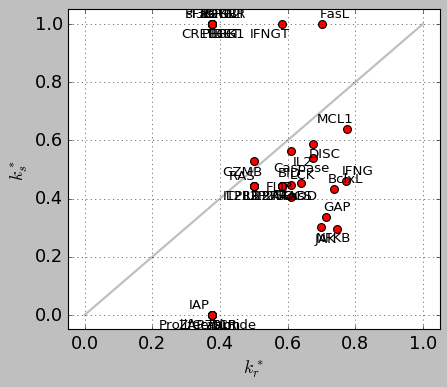

In [333]:
fig, ax = plt.subplots(1,1,figsize=(6,5), sharex=True, sharey=True)
dfp = df.loc[ (df['k']>1) , :]
ax.scatter(dfp['k_r*'],dfp['k_s*'], s=50, c='red', marker='o', zorder=2)
lx,ly = [],[]
quadrants = [-0.035,0.035]
for name, dfp_ in dfp.iterrows():
    x,y = dfp_['k_r*']+random.choice(quadrants) , dfp_['k_s*']+random.choice(quadrants)
    ax.annotate(name, (x,y),fontsize=12, va='center', ha='center')
    lx.append(x); ly.append(y)
ax.plot((0,1),(0,1),'black', lw=2,alpha=0.25, zorder=1)
ax.grid(True)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel('$k_r^*$')
ax.set_ylabel('$k_s^*$')
plt.savefig('../experiments/2017 - BioModels/%s/plots/k_sn_vs_k_rn.pdf' % (foldername), dpi=150)

In [334]:
#df = df.loc[ (df['k']>1) , :]
print df.sort_values('k',ascending=False).to_latex()
"""
multi_column_display([
        df[['k']].sort_values('k',ascending=False).to_html(),
        df[['k_r']].sort_values('k_r',ascending=False).to_html(),
        df[['k_e']].sort_values('k_e',ascending=False).to_html(),
        df[['k_s']].sort_values('k_s',ascending=False).to_html(),
        df[['k_r*']].sort_values('k_r*',ascending=False).to_html(),
        df[['k_e*']].sort_values('k_e*',ascending=False).to_html(),
        df[['k_s*']].sort_values('k_s*',ascending=False).to_html(),
        df[['k_e(out-d)']].sort_values('k_e(out-d)',ascending=False).to_html(),
        df[['k_e(out-s)']].sort_values('k_e(out-s)',ascending=False).to_html()
    ],['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)'],7 )
"""

\begin{tabular}{lrrrrrrrrr}
\toprule
{} &  k &  k\_r &  k\_e &  k\_s &  k\_r* &  k\_e* &  k\_s* &  k\_e(out-d) &  k\_e(out-s) \\
node          &    &      &      &      &       &       &       &             &             \\
\midrule
IFNG          &  6 &  4.6 &  1.4 &  2.8 &  0.77 &  0.23 &  0.46 &           5 &         1.2 \\
JAK           &  6 &  4.5 &  1.5 &  1.8 &  0.75 &  0.25 &   0.3 &           3 &         1.8 \\
GAP           &  5 &  3.6 &  1.4 &  1.7 &  0.71 &  0.29 &  0.34 &           2 &        0.81 \\
BclxL         &  5 &  3.7 &  1.3 &  2.2 &  0.74 &  0.26 &  0.43 &           1 &        0.38 \\
Caspase       &  5 &  3.4 &  1.6 &  2.7 &  0.68 &  0.33 &  0.54 &           2 &         1.1 \\
DISC          &  5 &  3.4 &  1.6 &  2.9 &  0.68 &  0.33 &  0.59 &           4 &         1.7 \\
NFKB          &  5 &  3.5 &  1.5 &  1.5 &   0.7 &   0.3 &   0.3 &          11 &         5.5 \\
MCL1          &  5 &  3.9 &  1.1 &  3.2 &  0.78 &  0.23 &  0.64 &           1 &        0.38 \\
BID    

"\nmulti_column_display([\n        df[['k']].sort_values('k',ascending=False).to_html(),\n        df[['k_r']].sort_values('k_r',ascending=False).to_html(),\n        df[['k_e']].sort_values('k_e',ascending=False).to_html(),\n        df[['k_s']].sort_values('k_s',ascending=False).to_html(),\n        df[['k_r*']].sort_values('k_r*',ascending=False).to_html(),\n        df[['k_e*']].sort_values('k_e*',ascending=False).to_html(),\n        df[['k_s*']].sort_values('k_s*',ascending=False).to_html(),\n        df[['k_e(out-d)']].sort_values('k_e(out-d)',ascending=False).to_html(),\n        df[['k_e(out-s)']].sort_values('k_e(out-s)',ascending=False).to_html()\n    ],['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)'],7 )\n"

In [ ]:
bound = 'upper'
for i,n in enumerate(N.nodes):
    display(HTML('<h2>'+n.name+'</h2>'))
    print 'Inputs:',n.inputs
    k = n.k
    k_r = n.input_redundancy(mode='node',bound=bound,norm=False)
    k_r_n = n.input_redundancy(mode='node',bound=bound,norm=True)
    k_e = n.effective_connectivity(mode='node', bound=bound, norm=False)
    k_s = n.input_symmetry(mode='node',bound=bound,norm=False)
    k_s_n = n.input_symmetry(mode='node',bound=bound,norm=True)
    
    dfS = pd.DataFrame([('k',k),('k_r',k_r),('k_e',k_e),('k_s',k_s),('k_r*',k_r_n),('k_s*',k_s_n)]).set_index(0).T
    #display(dfS)
    
    pi = n.schemata_look_up_table(type='pi',format='latex', ts_symbol_latex="\circ")
    ts = n.schemata_look_up_table(type='ts',format='latex', ts_symbol_latex="\circ")
    #display(Latex(pi))
    #display(Latex(ts))
    #multi_column_display([pi,ts],titles=['Prime Implicants','Two-Symbol Schemtas'],cols=4)

    # to make sure each SVG renders independently, add the "metadata={'isolated':True}
    CM = n.canalizing_map()
    gv = draw_canalizing_map_graphviz(CM)
    print CM
    display(SVG(gv.pipe(format='svg')),metadata={'isolated':True})

    # Export to .SVG
    filename = n.name
    filename = filename.replace(',','_')
    filename = filename.replace('/','_')
    gv._format = 'svg'
    efile = u'%s/../experiments/2017 - BioModels/%s/CM/%s-%s' % (os.getcwd(),foldername,i,filename)
    gv.render(efile, cleanup=True)
    subprocess.call("inkscape -z -d 150 '%s.svg' -e '%s.png'" % (efile,efile) , shell=True)

    #break

In [352]:
# Request the DCM to the Network
DCM = N.dynamics_canalization_map(output=None)
# Draws using the graphviz interface.
D = draw_dynamics_canalization_map_graphviz(DCM, overlap='true')
#display(D)

# Export to .SVG
D._format = 'svg'
efile = u'%s/../experiments/2017 - BioModels/%s/DCM/DCM' % (os.getcwd(), foldername)
D.render(efile, cleanup=True)
subprocess.call("inkscape -z -d 150 '%s.svg' -e '%s.png'" % (efile,efile) , shell=True)


0

In [354]:
def plot_schemata(nid, n):
    # Init values from BooleanNode
    k = n.k if n.k>=1 else 1
    inputs = n.inputs if not n.constant else [n.name]
    pi0s,pi1s = n._prime_implicants
    ts0s,ts1s = n._two_symbols
    # Count number of PI and TS
    n_pi = sum(len(pis) for pis in [pi0s,pi1s])
    n_ts = sum(len(tss) for tss in [ts0s,ts1s])
    # Schemata Cell Width and spacing
    cwidth = 60.
    cxspace = 0
    cyspace = 6
    border = 1
    sepcxspace = 21
    sepcyspace = 15
    dpi = 150.
    # Margins
    top, right, bottom, left, hs = 160, 25, 25, 60, 60
    # Axes Width & Height
    ax1width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax1height = (n_pi*(cwidth+cyspace)+sepcyspace-cyspace)
    ax2width = ((k*(cwidth+cxspace))+sepcxspace+(cwidth))
    ax2height = (n_ts*(cwidth+cyspace)+sepcyspace-cyspace)
    # Figure Width & Height
    fwidth = (left + ax1width + hs + ax2width + right)
    fheight = (bottom + max(ax1height,ax2height) + top)
    # Percentages for Axes location
    _ax1w = ((ax1width*100) / fwidth) / 100
    _ax2w = ((ax2width*100) / fwidth) / 100
    _ax1h = ((ax1height*100) / fheight) / 100
    _ax2h = ((ax2height*100) / fheight) / 100
    _bottom = ((bottom*100) / fheight) / 100
    _left = ((left*100) / fwidth) / 100
    _hs = ((hs*100) / fwidth) / 100
    # Init Figure
    fig = plt.figure(figsize=(fwidth/dpi,fheight/dpi), dpi=dpi)
    ax1 = fig.add_axes((_left,_bottom,_ax1w,_ax1h), aspect=1, label='PI')
    ax2 = fig.add_axes((_left+_ax1w+_hs,_bottom,_ax2w,_ax1h), aspect=1, label='TS')

    ### PI Plot ###

    yticks = []
    patches = []
    x,y = 0.,0.
    #
    for out,pis in zip([1,0],[pi1s,pi0s]):
        for pi in pis:
            x = 0.
            xticks = []
            for input in pi:
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'            
                text = '%s'%(input) if (input!='2') else '#'
                ax1.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='black')
                patches.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='black')
            ax1.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/10*4, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax1.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            patches.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
        y += sepcyspace

    ax1.add_collection(PatchCollection(patches,match_original=True))
    #
    ax1.set_yticks(yticks)
    ax1.set_yticklabels([r"$f^{'}_{%d}$"%(i+1) for i in range(n_pi)[::-1]], fontsize=14)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(inputs + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax1.xaxis.tick_top()
    # Remove Tick
    ax1.tick_params(which='major',pad=7)
    for tic in ax1.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax1.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    # Limits
    ax1.set_xlim(-border,ax1width+border)
    ax1.set_ylim(-border,ax1height+border)
    #ax1.invert_yaxis() 

    ## TS ##

    t = 0
    x,y = 0.,0.
    yticks = []
    boxes,symbols = [], []
    #
    tssymbols = [
        Circle((None,None), radius=5, facecolor='white', edgecolor='black'),
        RegularPolygon((None,None),numVertices=3, radius=5, orientation=0, facecolor='white', edgecolor='black'),
    ]
    #
    for out,tss in zip([1,0],[ts1s,ts0s]):
        for ts,pss,sss in tss:
            x = 0.
            xticks = []
            for i,input in enumerate(ts):
                if input == '0':
                    facecolor = 'white'
                    textcolor = 'black'
                elif input == '1':
                    facecolor = 'black'
                    textcolor = 'white'
                elif input == '2':
                    facecolor = '#cccccc'
                    textcolor = 'black'

                if len(pss):
                    # TODO: If there are several symbols in the same input position, place them side-by-side
                    iinpss = [j for j,ps in enumerate(pss) if i in ps]
                    xpos = np.linspace(x,x+cwidth, len(iinpss)+2)
                    for z,j in enumerate(iinpss,start=1):
                        s = copy(tssymbols[j])
                        s.xy = (xpos[z],y+cwidth*0.8)
                        s.center = xpos[z],y+cwidth*0.8 # A hack for circles only
                        s.set_edgecolor('#a6a6a6' if (input=='1') else 'black')
                        symbols.append(s)
                        ax2.add_patch(s)

                text = '%s'%(input) if (input!='2') else '#'
                ax2.add_artist(Text(x+cwidth/2,y+cwidth/10*4, text=text, color=textcolor, va='center', ha='center',fontsize=14,family='serif'))
                r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor=facecolor, edgecolor='#4c4c4c',zorder=2)
                boxes.append(r)
                xticks.append(x+cwidth/2)
                x += cwidth + cxspace

            x += sepcxspace
            r = Rectangle((x,y), width=cwidth, height=cwidth, facecolor='black' if (out==1) else 'white', edgecolor='#4c4c4c')
            ax2.add_artist(Text(x-(sepcxspace/2)-(cxspace/2),y+cwidth/2, text=':', color='black', va='center', ha='center',fontsize=14,weight='bold',family='serif'))
            ax2.add_artist(Text(x+(cwidth/2),y+cwidth/10*4, text=out, color='white' if (out==1) else 'black', va='center', ha='center',fontsize=14,family='serif'))
            boxes.append(r)
            xticks.append(x+cwidth/2)
            yticks.append(y+cwidth/2)
            y += cwidth + cyspace
            t += 1
        y += sepcyspace

    if len(boxes):
        ax2.add_collection(PatchCollection(boxes,match_original=True))
    if len(symbols):
        ax2.add_collection(PatchCollection(symbols,match_original=True))
    #
    ax2.set_yticks(yticks)
    ax2.set_yticklabels([r"$f^{''}_{%d}$"%(i+1) for i in range(n_ts)[::-1]], fontsize=14)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(inputs + ['%s'%(n.name)], rotation=90, fontsize=14)
    #
    ax2.xaxis.tick_top()
    # Remove Tick
    ax2.tick_params(which='major',pad=7)
    for tic in ax2.xaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    for tic in ax2.yaxis.get_major_ticks():
        tic.tick1On = tic.tick2On = False
    # Remove Border
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    # Limits
    ax2.set_xlim(-border,ax2width+border)
    ax2.set_ylim(-border,ax2height+border)

    # FileName
    filename = n.name.replace('/','_')
    filename = filename.replace(',','_')
    ### SAVE to FILE ###
    plt.savefig('%s/../experiments/2017 - BioModels/%s/schematas/%s-%s' % (os.getcwd(), foldername, nid, filename), dpi=dpi)
    plt.close()

In [ ]:
for nid,n in enumerate(N.nodes):
    print 'Plotting: %s - %s' % (nid,n.name)
    # Compute Prime Implicants & Two-Symbol schematas
    n._check_compute_canalization_variables(prime_implicants=True)
    n._check_compute_canalization_variables(two_symbols=True)
    # Plot
    plot_schemata(nid,n)

Plotting: 0 - CTLA4
Plotting: 1 - TCR
Plotting: 2 - PDGFR
Plotting: 3 - FYN
Plotting: 4 - Cytoskeleton
Plotting: 5 - LCK
Plotting: 6 - ZAP70
Plotting: 7 - GRB2
Plotting: 8 - PLCG1
Plotting: 9 - RAS
Plotting: 10 - GAP
Plotting: 11 - MEK
Plotting: 12 - ERK
Plotting: 13 - PI3K
Plotting: 14 - NFKB
Plotting: 15 - NFAT
Plotting: 16 - RANTES
Plotting: 17 - IL2
Plotting: 18 - IL2RBT
Plotting: 19 - IL2RB
Plotting: 20 - IL2RAT
Plotting: 21 - IL2RA
Plotting: 22 - JAK
Plotting: 23 - SOCS
Plotting: 24 - STAT3
Plotting: 25 - P27
Plotting: 26 - Proliferation
Plotting: 27 - TBET
Plotting: 28 - CREB
Plotting: 29 - IFNGT
Plotting: 30 - IFNG